<a href="https://colab.research.google.com/github/roywaswa/gee_learner/blob/main/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
# import folium

In [2]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [3]:
landcover = ee.ImageCollection('MODIS/006/MCD12Q1')
land_surface_temp = ee.ImageCollection('MODIS/006/MOD11A1')
elevation = ee.Image('USGS/SRTMGL1_003')

In [4]:
start_date= '2017-01-01'
end_date='2020-01-01'
land_surface_temp = land_surface_temp.select('LST_Day_1km', 'QC_Day').filterDate(start_date, end_date)

In [5]:
# coordinates of the area of interest Nairobi, Kenya
u_lon = 36.82
u_lat = -1.28
u_point = ee.Geometry.Point(u_lon, u_lat)

# get the land surface temperature for the area of interest Juja, Kenya
r_lon = 37.11
r_lat = -1.18
r_point = ee.Geometry.Point(r_lon, r_lat)


In [6]:
scale = 1000

elv_urban_area = elevation.sample(u_point, scale).first().get('elevation').getInfo()
lst_urban_area = land_surface_temp.mean().sample(u_point, scale).first().get('LST_Day_1km').getInfo()
lc_urban_area = landcover.first().sample(u_point, scale).first().get('LC_Type1').getInfo()


print('Elevation of urban area: ', elv_urban_area)
print('Land surface temperature of urban area: ', round(lst_urban_area*0.02 -273.15, 2), '°C')
print('Land cover of urban area: ', lc_urban_area)


Elevation of urban area:  1670
Land surface temperature of urban area:  30.47 °C
Land cover of urban area:  13


In [7]:
lst_urban_point = land_surface_temp.getRegion(u_point, scale).getInfo()
lst_rural_point = land_surface_temp.getRegion(r_point, scale).getInfo()

lst_urban_point[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  36.81745191963859,
  -1.2800992798703181,
  1483228800000,
  None,
  2],
 ['2017_01_02',
  36.81745191963859,
  -1.2800992798703181,
  1483315200000,
  15340,
  81],
 ['2017_01_03',
  36.81745191963859,
  -1.2800992798703181,
  1483401600000,
  15253,
  81],
 ['2017_01_04',
  36.81745191963859,
  -1.2800992798703181,
  1483488000000,
  15376,
  81]]

In [8]:
import pandas as pd

def ee_array_to_pandas_df(ee_array, list_of_bands):
    df = pd.DataFrame(ee_array)

    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')
    
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    df = df[['time', 'datetime', *list_of_bands]]

    return df

In [9]:
lst_df_urban = ee_array_to_pandas_df(lst_urban_point,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_pandas_df(lst_rural_point,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
1,1483315200000,2017-01-02,33.65
2,1483401600000,2017-01-03,31.91
3,1483488000000,2017-01-04,34.37
5,1483660800000,2017-01-06,33.31
6,1483747200000,2017-01-07,35.09


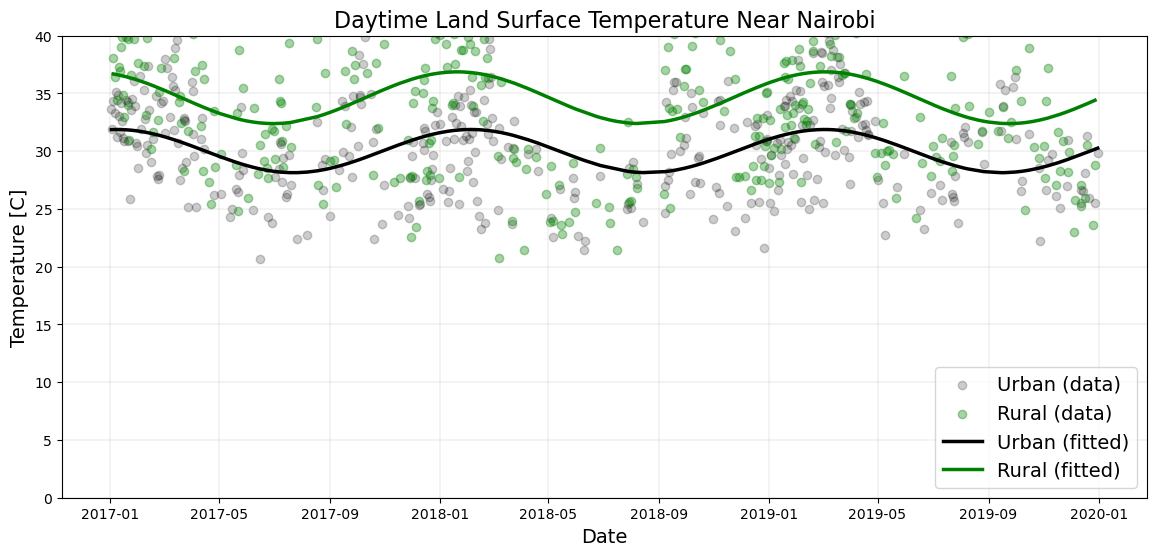

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Nairobi', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [27]:
# Define a region of interest with a buffer zone of 1000 km around Lyon.
roi = u_point.buffer(1e6)
# Reduce the LST collection by mean.
lst_img = land_surface_temp.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)


In [28]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 25, 'max': 35, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6640eae43924f58b56124f81bfbee42d-43ad04522153165b04a8ed2f25962f96:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [29]:
# Make pixels with elevation below sea level transparent.
elv_img = elevation.updateMask(elevation.gt(0))

# Display the thumbnail of styled elevation in France.
Image(url=elv_img.getThumbURL({
    'min': 1000, 'max': 5000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

In [31]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset Kenya.
kenya = countries.filter(ee.Filter.eq('ADM0_NAME', 'Kenya'))

# Clip the image by France.
elv_ke = elv_img.clip(kenya)

# Create the URL associated with the styled image data.
url = elv_ke.getThumbUrl({
    'min': 0, 'max': 5000, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in France.
Image(url=url)

In [32]:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_near_nairobi',
                                     scale=30,
                                     region=kenya,
                                     fileNamePrefix='my_export_kenya',
                                     crs='EPSG:32636',
                                     fileFormat='GeoTIFF')
task.start()

In [35]:
link = lst_img.getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': kenya})
print(link)

EEException: Image.clipToBoundsAndScale, argument 'geometry': Invalid type.
Expected type: Geometry.
Actual type: FeatureCollection.